In [1]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
include("lsx.jl")
#include("meta-bandit.jl")
include("ucb1tuned.jl")

update! (generic function with 4 methods)

In [2]:
using Plots
using Statistics
using Distributions
#using Base.Threads

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1186


In [3]:
mutable struct Tompson <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    w::Vector{Float64}             #numbers of selection of each arm.
    l::Vector{Float64}             #sum of an earned reward of each arm
    #constructor
    function Tompson(env::Environment)
        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num))
    end
end

In [4]:
function init!(algo::Tompson)
    algo.actionValues = zeros(algo.env.arm_num)
    algo.w = zeros(algo.env.arm_num)
    algo.l = zeros(algo.env.arm_num)
end


function select_arm(algo::Tompson)
#     min, minidx = findmin(algo.actionValues)
#     if min == 0
#         return minidx
#     end
    #return index of maximum value in the action values.
    return greedy(algo)
end

function calc_value(algo::Tompson, selected)
    
    #beta_dist = Beta(algo.w[selected]+1., algo.l[selected]+1.)
    beta_dists = [Beta(algo.w[i]+1., algo.l[i]+1.) for i=1:algo.env.arm_num]
    for i=1:algo.env.arm_num
        algo.actionValues[i] = rand(beta_dists[i])
    end
    
end

#chose arm and update each parameter.
function update!(algo::Tompson)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #calculation of action value and save.
    calc_value(algo, selected)
    
        #update this experiment's current state.
    if reward == 1
        algo.w[selected] += 1.
    else
        algo.l[selected] += 1.
    end

    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end


update! (generic function with 5 methods)

In [5]:
function simulation(;sim_num::Int, steps::Int, update_per::Int, arm_num=4, dynamic=false)
    #argument checking.
    if dynamic && update_per <= steps && steps % update_per != 0
        println("update number error.")
        return
    end

    update_num = div(steps, update_per)#convert(Int64, steps/update_per)
    env = Environment(arm_num)

    algo_dict = Dict()
    
    algo_dict["RS"] = RS(env)
    #algo_dict["UCB1"] = UCB1(env, false)
    algo_dict["UCB1 tuned"] = UCB1(env, true)
    algo_dict["Tompson_sampling"] = Tompson(env)

    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            ds = rand(update_num,arm_num)
            update_env!(env, ds[1, :])
            init!(algorithm)
            regret = 0.
            
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                
                if dynamic
                    if step % update_per == 0
                        ds_idx = div(step, update_per)
                        update_env!(env, ds[ds_idx+1, :])
                        #println("<----------updated------------->")
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX && algorithm.opt
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        elseif typeof(algorithm) == MYRS
                            if algorithm.opt
                                sorted_pro = sort(env.arm_pros, rev=true)
                                algorithm.r = (sorted_pro[1] + sorted_pro[2]) / 2
                            end
                        end
                    end
                end

            end
            if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
        
    end
    
    println("DONE.")
    
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = vcat(rslist...)
    #@show size(graph_data2)
    graph_data2 = hcat(regret_means...)

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [ ]:
@time g1, g2, algo_dict = simulation(sim_num=100,
                            steps=20000,
                            update_per=10000,
                            arm_num=20,
                            dynamic=false);

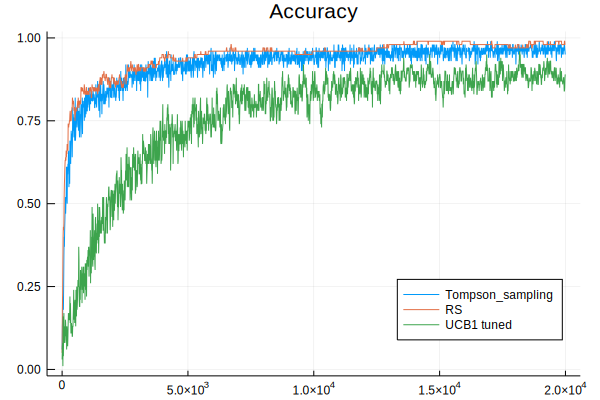

In [60]:
step_axis = [i for i=1:10:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)